# visual debugging

In [211]:
import random
import numpy as np
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from skimage.transform import resize

import os
import matplotlib.pyplot as plt
from PIL import Image
import json
import torch
from torchvision import transforms

In [278]:
idir = '/home-2/jwei9@jhu.edu/work2/mamba/scoliosis/ifcn/data/train/0'
files = os.listdir(idir)
files.sort()

In [279]:
files

['image_phi=82_theta=98.tiff',
 'vertebra_0_image_phi=82_theta=98.tiff',
 'vertebra_10_image_phi=82_theta=98.tiff',
 'vertebra_11_image_phi=82_theta=98.tiff',
 'vertebra_12_image_phi=82_theta=98.tiff',
 'vertebra_13_image_phi=82_theta=98.tiff',
 'vertebra_14_image_phi=82_theta=98.tiff',
 'vertebra_15_image_phi=82_theta=98.tiff',
 'vertebra_16_image_phi=82_theta=98.tiff',
 'vertebra_17_image_phi=82_theta=98.tiff',
 'vertebra_18_image_phi=82_theta=98.tiff',
 'vertebra_19_image_phi=82_theta=98.tiff',
 'vertebra_20_image_phi=82_theta=98.tiff',
 'vertebra_21_image_phi=82_theta=98.tiff',
 'vertebra_7_image_phi=82_theta=98.tiff',
 'vertebra_8_image_phi=82_theta=98.tiff',
 'vertebra_9_image_phi=82_theta=98.tiff',
 'weight_vertebra_0_image_phi=82_theta=98.tiff',
 'weight_vertebra_10_image_phi=82_theta=98.tiff',
 'weight_vertebra_11_image_phi=82_theta=98.tiff',
 'weight_vertebra_12_image_phi=82_theta=98.tiff',
 'weight_vertebra_13_image_phi=82_theta=98.tiff',
 'weight_vertebra_14_image_phi=82_th

In [280]:
allfiles = files
mask_json_path = r'data/mapping.json'
with open(mask_json_path, 'r') as f:
    mask = json.load(f)
mask_num = len(mask)
mask_value = [value for value in mask.values()]
mask_value.sort()  # 0 to 26

In [281]:
sample_data = files[0]
sample_data = Image.open(os.path.join(idir, sample_data))
# sample_data = sample_data.resize((320, 640))  # PIL flipped for some reason
sample_data = np.array(sample_data)
height, width = np.shape(sample_data)

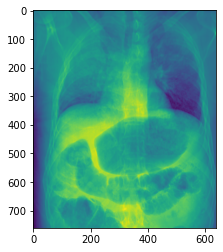

In [282]:
plt.imshow(sample_data)

In [283]:
mask_array = np.zeros((height, width, mask_num))
weight_array = np.zeros((height, width, mask_num))
verts = []  # list of unique vertebra

for i in range(len(allfiles)):
    filename = allfiles[i]
    if filename.startswith('image'):
        img_name = filename
    elif filename.startswith('vertebra'):
        vertebra_num = np.uint8(filename.split('_')[1])
        rawpath = os.path.join(idir, filename)
        raw = Image.open(rawpath)
        raw = np.array(raw)
        mask_array[:,:,vertebra_num] = raw
        verts.append(vertebra_num)
    elif filename.startswith('weight'):
        vertebra_num = np.uint8(filename.split('_')[2])
        rawpath = os.path.join(idir, filename)
        raw = Image.open(rawpath)
        raw = np.array(raw)
        weight_array[:,:,vertebra_num] = raw

In [284]:
img = Image.open(os.path.join(idir, img_name)).convert('RGB')
img = np.array(img)
mask = mask_array
weight = weight_array

img = np.float32(img)
mask = np.float32(mask)
weight = np.float32(weight)

In [292]:
def force_inside_img(x, patch_size, img_shape, dim=0):
    x_low = int(x - patch_size / 2)
    x_up = int(x + patch_size / 2)
    if x_low < 0:
        x_up -= x_low
        x_low = 0
    elif x_up > img_shape[dim]:  # 2d, is [2] in github
        x_low -= (x_up - img_shape[dim])
        x_up = img_shape[dim]
    return x_low, x_up

In [293]:
def gaussian_blur(image):
    return gaussian_filter(image, sigma=1)


def gaussian_noise(image):
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    gauss = 50 * np.random.normal(mean, sigma, image.shape)
    gauss = gauss.reshape(image.shape)
    return image + gauss


def random_crop(image, ins, gt, weight, depth=80):
    out_shape = np.shape(image)  # (128, 128, 3)  # originally 128x128x3
    out_shape_layered = np.shape(ins)
    start = random.randint(0, image.shape[0] - depth - 1)

    image = crop_z(image, start, start + depth)
    ins = ins[start:start+depth,:,:]
    gt = gt[start:start+depth,:,:]
    weight = weight[start:start+depth,:,:]

    crop_img = resize(image, out_shape, order=1, preserve_range=True)
    crop_ins = resize(ins, out_shape_layered, order=0, preserve_range=True)
    crop_gt = resize(gt, out_shape_layered, order=0, preserve_range=True)
    crop_weight = resize(weight, out_shape_layered, order=1, preserve_range=True)

    return crop_img, crop_ins, crop_gt, crop_weight


def crop_z(arr, start, end):
    return arr[start:end]

In [294]:
def extract_random_patch(img, mask, weight, verts, idx, subset, empty_interval=5, patch_size=128):
    flag_empty = False

    # list available vertebrae
    # verts = np.unique(mask)  # passed from dataloader
    chosen_vert = verts[random.randint(1, len(verts) - 1)]  # avoid 0, background

    # create corresponde instance memory and ground truth - goes bottom to top
    # ins_memory = np.copy(mask)  # you can basically do this too and set others to 0
    height, width, layers = np.shape(mask)
    ins_memory = np.zeros((height, width, layers))

    for layer in range(layers):  # basically, if vert is above or equal to chosen, set to 0, else 1
        cur_layer = mask[:,:,layer]
        if layer <= chosen_vert:
            continue  # stays 0
        else:
            ins_memory[:,:,layer] = cur_layer  # change to 1
    
    gt = np.zeros((height, width, layers))
    gt[:,:,chosen_vert] = mask[:,:,chosen_vert]  # ground truth is current vertebrae only

    # send empty mask sample in certain frequency
    if i % empty_interval == 0:  # every 5 iterations, send empty
        patch_center = [np.random.randint(0, s) for s in img.shape]
        x = patch_center[0]  # should be right... x is [0] (height)
        y = patch_center[1]

        # for instance memory
        gt = np.copy(mask)  # will modify later
        flag_empty = True
    else:
        # indices = np.nonzero(mask == chosen_vert)
        indices = np.nonzero(mask[:,:,chosen_vert])
        lower = [np.min(i) for i in indices]
        upper = [np.max(i) for i in indices]
        # random center of patch
        x = random.randint(lower[0], upper[0])  # should be right... x is [0] (height)
        y = random.randint(lower[1], upper[1])

    # force random patches' range within the image
    x_low, x_up = force_inside_img(x, patch_size, img.shape, dim=0)
    y_low, y_up = force_inside_img(y, patch_size, img.shape, dim=1)

    # crop the patch
    img_patch = img[x_low:x_up, y_low:y_up]
    ins_patch = ins_memory[x_low:x_up, y_low:y_up, :]
    gt_patch = gt[x_low:x_up, y_low:y_up, :]
    weight_patch = weight[x_low:x_up, y_low:y_up, :]

    #  if the label is empty mask
    if flag_empty:
        ins_patch = np.copy(gt_patch)
        gt_patch = np.zeros_like(ins_patch)
        weight_patch = np.ones_like(ins_patch)  # empty patch has no weight preference

    # Randomly on-the-fly Data Augmentation
    # 50% chance elastic deformation
    if subset == 'train':
        if np.random.rand() > 0.5:
            img_patch, gt_patch, ins_patch, weight_patch = elastic_transform(img_patch, gt_patch, ins_patch,
                                                                             weight_patch, alpha=20, sigma=5)
        # 50% chance gaussian blur
        if np.random.rand() > 0.5:
            img_patch = gaussian_blur(img_patch)
        # 50% chance gaussian noise
        if np.random.rand() > 0.5:
            img_patch = gaussian_noise(img_patch)

        # 50% random crop along z-axis
        if np.random.rand() > 0.5:
            img_patch, ins_patch, gt_patch, weight_patch = random_crop(img_patch, ins_patch, gt_patch
                                                                       , weight_patch)

    # decide label of completeness (partial or complete)
    vol = np.count_nonzero(gt == 1)
    sample_vol = np.count_nonzero(gt_patch == 1)
    c_label = 0 if float(sample_vol / (vol + 0.0001)) < 0.98 else 1

    img_patch = np.expand_dims(img_patch, axis=0)
    ins_patch = np.expand_dims(ins_patch, axis=0)
    gt_patch = np.expand_dims(gt_patch, axis=0)
    weight_patch = np.expand_dims(weight_patch, axis=0)
    c_label = np.expand_dims(c_label, axis=0)

    return img_patch, ins_patch, gt_patch, weight_patch, c_label


In [295]:
def elastic_transform(image, mask, ins, weight, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       
       Modified from: https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z + dz, (-1, 1))
    indices_layered = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    distorted_image = map_coordinates(image, indices, order=1, mode='reflect')
    layers = np.shape(mask)[2]
    distorted_mask = np.zeros(np.shape(mask))
    distorted_ins = np.zeros(np.shape(ins))
    distorted_weight = np.zeros(np.shape(weight))
    for layer in range(layers):
        distorted_mask[:,:,layer] = map_coordinates(mask[:,:,layer], indices_layered, order=1, mode='reflect')
        distorted_ins[:,:,layer] = map_coordinates(ins[:,:,layer], indices_layered, order=1, mode='reflect')
        distorted_weight[:,:,layer] = map_coordinates(weight[:,:,layer], indices_layered, order=1, mode='reflect')

    return distorted_image.reshape(image.shape), distorted_mask.reshape(mask.shape), distorted_ins.reshape(
        ins.shape), distorted_weight.reshape(weight.shape)

In [296]:
# specific to IFCN: extract training patch. gt = ground truth
subset = 'train'
empty_interval = 5
patch_size = 256
idx = 1

In [297]:
flag_empty = False

# list available vertebrae
# verts = np.unique(mask)  # passed from dataloader
chosen_vert = verts[random.randint(1, len(verts) - 1)]  # avoid 0, background

# create corresponde instance memory and ground truth - goes bottom to top
# ins_memory = np.copy(mask)  # you can basically do this too and set others to 0
height, width, layers = np.shape(mask)
ins_memory = np.zeros((height, width, layers))

for layer in range(layers):  # basically, if vert is above or equal to chosen, set to 0, else 1
    cur_layer = mask[:,:,layer]
    if layer <= chosen_vert:
        continue  # stays 0
    else:
        ins_memory[:,:,layer] = cur_layer  # change to 1

gt = np.zeros((height, width, layers))
gt[:,:,chosen_vert] = mask[:,:,chosen_vert]  # ground truth is current vertebrae only

# send empty mask sample in certain frequency
if i % empty_interval == 0:  # every 5 iterations, send empty
    patch_center = [np.random.randint(0, s) for s in img.shape]
    x = patch_center[0]  # should be right... x is [0] (height)
    y = patch_center[1]

    # for instance memory
    gt = np.copy(mask)  # will modify later
    flag_empty = True
else:
    # indices = np.nonzero(mask == chosen_vert)
    indices = np.nonzero(mask[:,:,chosen_vert])
    lower = [np.min(i) for i in indices]
    upper = [np.max(i) for i in indices]
    # random center of patch
    x = random.randint(lower[0], upper[0])  # should be right... x is [0] (height)
    y = random.randint(lower[1], upper[1])

# force random patches' range within the image
x_low, x_up = force_inside_img(x, patch_size, img.shape)
y_low, y_up = force_inside_img(y, patch_size, img.shape)

# crop the patch
img_patch = img[x_low:x_up, y_low:y_up]
ins_patch = ins_memory[x_low:x_up, y_low:y_up, :]
gt_patch = gt[x_low:x_up, y_low:y_up, :]
weight_patch = weight[x_low:x_up, y_low:y_up, :]

img_patch = gaussian_blur(img_patch)
# img_patch = gaussian_noise(img_patch)

7


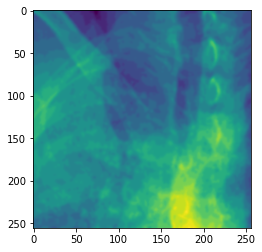

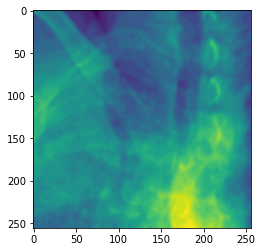

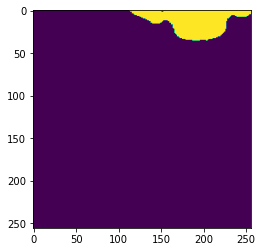

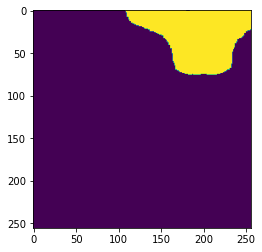

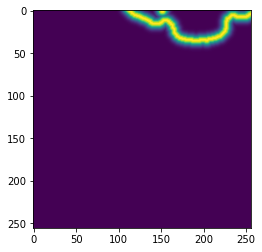

In [302]:
print(chosen_vert)
img_patch_new = img_patch[:,:,0]
plt.imshow(img_patch_new); plt.show()
plt.imshow(gaussian_blur(img_patch_new)); plt.show()

# gauss_noise = gaussian_noise(img_patch)
# plt.imshow(gauss_noise[:,:,0]); plt.show()

plt.imshow(gt_patch[:,:,chosen_vert]); plt.show()
plt.imshow(ins_patch[:,:,chosen_vert+1]); plt.show()
plt.imshow(weight_patch[:,:,chosen_vert]); plt.show()

In [ ]:
# TODO: elastic transformation does not work yet with 26-layered arrays
img_patch_elastic, gt_patch_elastic, ins_patch_elastic, weight_patch_elastic = elastic_transform(img_patch, gt_patch, ins_patch, weight_patch, alpha=20, sigma=5)
plt.imshow(img_patch_elastic[:,:,1])

In [299]:
img_patch_c, ins_patch_c, gt_patch_c, weight_patch_c = random_crop(img_patch, ins_patch, gt_patch,
                                                                       weight_patch)

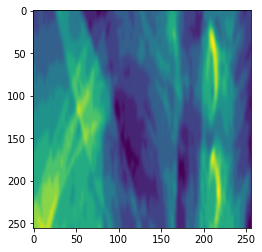

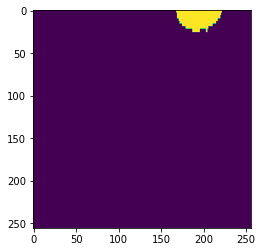

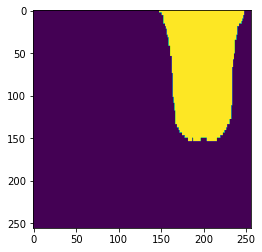

In [300]:
plt.imshow(img_patch_c[:,:,0]); plt.show()
plt.imshow(gt_patch_c[:,:,chosen_vert]); plt.show()
plt.imshow(ins_patch_c[:,:,chosen_vert+1]); plt.show()

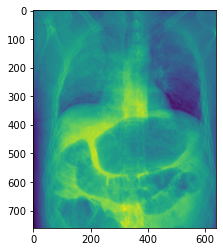

In [257]:
plt.imshow(img[:,:,0])

In [197]:
vol = np.count_nonzero(gt == 1)  # 2866
sample_vol = np.count_nonzero(gt_patch == 1)  # 2052
c_label = 0 if float(sample_vol / (vol + 0.0001)) < 0.98 else 1  # 0
print(c_label)

0

In [199]:
np.shape(np.expand_dims(img_patch, axis=0))

(1, 128, 128, 3)

### garbo

7

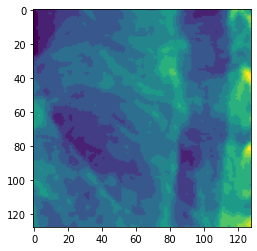

In [105]:
img_patch_int = img_patch[:,:,0].astype(int)
min = np.amin(img_patch_int)
max = np.amax(img_patch_int)

xdim, ydim = np.shape(img_patch_int)
for i in range(xdim):
    for j in range(ydim):
        value = img_patch_int[i, j]
        if value != 0:
            value -= min
            value *= 255
            value = int(np.around(value))
            img_patch_int[i, j] = value

plt.imshow(img_patch_int)
chosen_vert

In [203]:
np.shape(img_patch)

(128, 128, 3)

In [204]:
np.shape(ins_patch)

(128, 128, 26)

### see if you can concatenate tensors

In [206]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [226]:
img_tensor = train_transform(img_patch)
ins_tensor = train_transform(ins_patch)
gt_tensor = train_transform(ins_patch)
weight_tensor = train_transform(weight_patch)

In [218]:
np.shape(img_tensor)

torch.Size([3, 128, 128])

In [216]:
track2 = torch.cat((img_tensor, ins_tensor), dim=0)

In [219]:
np.shape(track2)

torch.Size([29, 128, 128])

In [231]:
print(type(c_label), c_label)
c_label = np.float32(c_label)

<class 'int'> 0


In [229]:
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Tesla K80


In [239]:
# c_label_tensor = train_transform(c_label)  # doesn't work
c_label_tensor = torch.tensor(c_label)

In [241]:
c_label_ex = np.expand_dims(c_label, axis=0)

In [245]:
torch.from_numpy(c_label_ex)

tensor([0.])

In [232]:
c_label_device = c_label.to(device)  # doesn't work

AttributeError: 'numpy.float32' object has no attribute 'to'

In [246]:
c_label_tensor.to(device)

tensor(0., device='cuda:0')

In [233]:
img_device = img_tensor.to(device)

In [240]:
type(c_label_tensor)

torch.Tensor